In [101]:
import open3d as o3d
import time
import skvideo.io 
import skimage.io
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Make Scikit-Video happy
np.float = np.float64
np.int = np.int_

In [102]:
DATA_PATH = Path("data/6070fae025")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


(1440, 1920, 3)


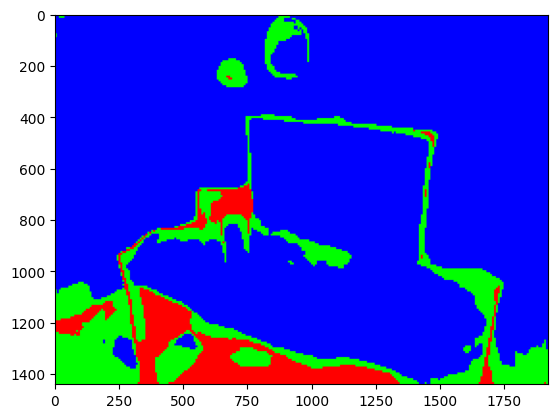

In [103]:
video_data = skvideo.io.vread(str(DATA_PATH.joinpath("rgb.mp4")))
rgb_image = video_data[0]

print(rgb_image.shape)

confidence_image = skimage.io.imread(sorted(list(DATA_PATH.glob("confidence/*.png")))[0])


new_rgb_image = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 3))
rgb_image = skimage.transform.resize(confidence_image, rgb_image.shape[0:2], order=0)

new_rgb_image[..., 0] = (rgb_image == 0)
new_rgb_image[..., 1] = (rgb_image == 1)
new_rgb_image[..., 2] = (rgb_image == 2)

rgb_image = new_rgb_image * 255
plt.imshow(rgb_image)

In [104]:
calibration_matrix = np.genfromtxt(DATA_PATH.joinpath("camera_matrix.csv"), delimiter=',')
calibration_matrix

array([[1.3398461e+03, 0.0000000e+00, 9.5837756e+02],
       [0.0000000e+00, 1.3398461e+03, 7.2530835e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

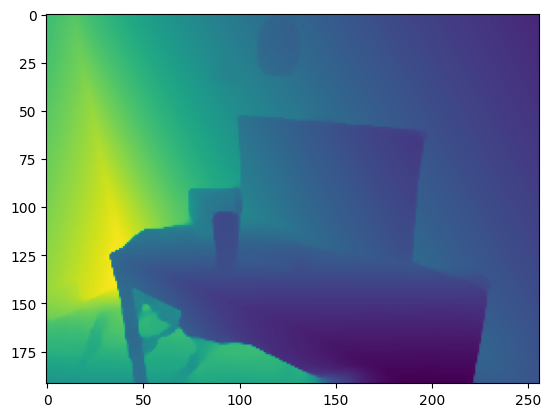

In [105]:
depth_image = skimage.io.imread(sorted(list(DATA_PATH.glob("depth/*.png")))[0])
plt.imshow(depth_image)

In [106]:
def image_to_point_cloud(calibration_matrix: np.array, rgb_image: np.array, depth_map: np.array) -> np.array:

    height = rgb_image.shape[0]
    width = rgb_image.shape[1]

    # Ray from Point in Image:
    # Ideas from https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
    # And https://stackoverflow.com/questions/68249598/how-to-calculate-the-ray-of-a-camera-with-the-help-of-the-camera-matrix

    camera_matrix_inv = np.linalg.inv(calibration_matrix)

    xv, yv = np.meshgrid(np.arange(width), np.arange(height))
    all_pixels = np.stack([xv.ravel(), yv.ravel(), np.ones_like(xv).ravel()], axis=1)


    # Upscale depth to the same as our RGB image
    upscaled_depth_image = skimage.transform.resize(depth_map, rgb_image.shape[0:2], order=0)


    directions = np.matmul(camera_matrix_inv, all_pixels.T).T
    directions = directions / np.linalg.norm(directions)
    point_cloud = directions * upscaled_depth_image.reshape(-1, 1) # Add Depth info!

    return point_cloud[:, 0:3]

In [107]:
point_cloud = image_to_point_cloud(calibration_matrix, rgb_image, depth_image)

# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=480, width=640)

pcd = o3d.geometry.PointCloud()

pcd.points = o3d.utility.Vector3dVector(point_cloud)

colors = (rgb_image.reshape(-1,3).astype('float32') / 255.0)
pcd.colors = o3d.utility.Vector3dVector(colors)

vis.add_geometry(pcd)

# run non-blocking visualization. 
# To exit, press 'q' or click the 'x' of the window.
keep_running = True
while keep_running:
    keep_running = vis.poll_events()
    vis.update_renderer()

vis.destroy_window()